In [1]:
from pfs.drp.stella import DetectorMap
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
afwDisplay.setDefaultBackend("matplotlib")
from astropy.stats import sigma_clip

import scipy
from scipy.ndimage import gaussian_filter1d, center_of_mass, median_filter

from matplotlib import animation, rc
from IPython.display import HTML
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from astropy.io import fits
from importlib import reload  

In [2]:
from pfs.utils.fiberids import FiberIds

In [3]:
import alefur.lib as alfib
reload(alfib)

<module 'alefur.lib' from '/home/afur/notebooks/alefur/lib.py'>

In [4]:
wmin, wmax = 625,975

In [5]:
dataId = dict(visit=None, arm="r", spectrograph=1)

In [6]:
import datetime as dt
from datetime import datetime, timedelta
from matplotlib.dates import date2num, num2date

def astro2num(astrotime):
    return (astrotime / 86400) - 50000 + date2num(datetime(1995, 10, 10))

In [7]:
gfm = FiberIds()
gfmDf = pd.DataFrame(gfm.data)

scienceFiberId = np.arange(2394) + 1
scienceFiber = gfmDf.set_index('scienceFiberId').loc[scienceFiberId].reset_index()

spec1 = scienceFiber.query('spectrographId==1').sort_values('fiberId')
fiberIds = spec1.fiberId.to_numpy()

In [8]:
import matplotlib
%matplotlib notebook

backendRatio = 0.8

In [9]:
mplColors = [col['color'] for col in plt.rcParams["axes.prop_cycle"]]

In [10]:
import matplotlib
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

backendRatio = 1

In [11]:
repoRoot = "/projects/HSC/PFS/Subaru"

In [12]:
calibRoot = os.path.join(repoRoot, 'CALIB-alefur-pfi')

In [13]:
butler = dafPersist.Butler(repoRoot, calibRoot=calibRoot)

In [14]:
rerun = '/projects/HSC/PFS/Subaru/rerun/alefur/pfi'

In [15]:
butlerSubtracted = dafPersist.Butler(rerun, calibRoot=calibRoot)

In [241]:
#sky
visit = 68878

In [202]:
#fiberTrace
visit = 69006

In [242]:
dataId.update(visit=visit)

In [243]:
detMap = butler.get('detectorMap', dataId)

In [244]:
fiberTraces = alfib.constructFiberTraces(detMap, fiberIds)

In [245]:
from lsst.ip.isr import IsrTask

config = IsrTask.ConfigClass()
config.doBias = True
config.doDark = True
config.doFringe = False
config.doFlat = False
config.doLinearize = False
config.doDefect = False
config.doAddDistortionModel = False
config.doSaturationInterpolation = False

isrTask = IsrTask(config=config)

In [246]:
sbias = butler.get('bias', dataId)
sdark = butler.get('dark', dataId)
#sflat = butler.get('flat', dataId)

In [247]:
%%time
#calexp = isrTask.run(raw, bias=sbias, dark=sdark, flat=sflat)
raw = butler.get('raw', dataId, filter=dataId['arm'])
calexp = isrTask.run(raw, bias=sbias, dark=sdark)
exp = calexp.exposure
yc = np.arange(0, exp.getHeight())

CPU times: user 2.37 s, sys: 771 ms, total: 3.14 s
Wall time: 3.14 s


In [248]:
%matplotlib notebook

<IPython.core.display.Javascript object>


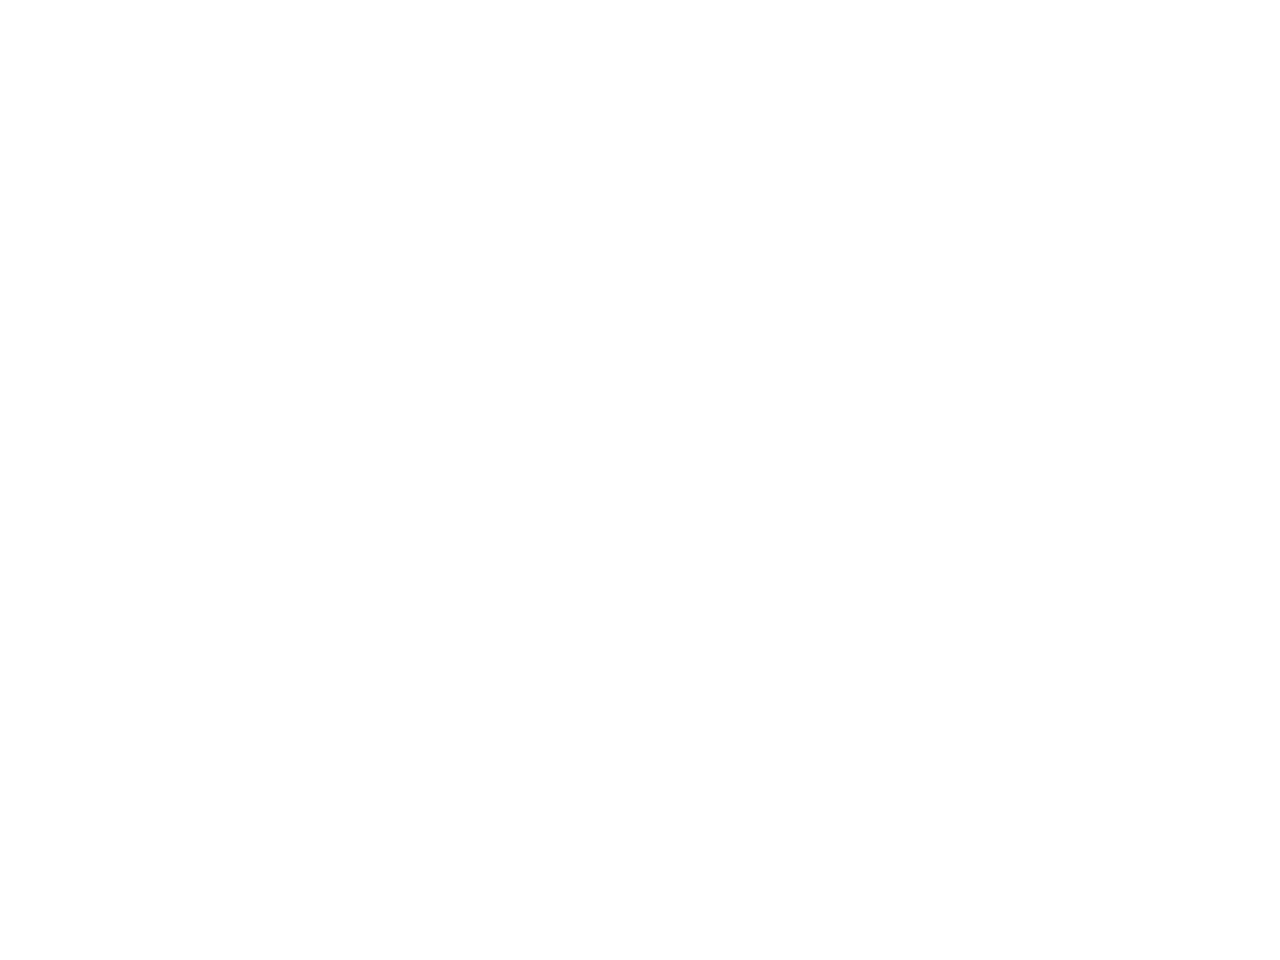

In [249]:
disp = afwDisplay.Display(0, )
disp.scale('asinh', 'zscale')
disp.mtv(exp, title=f"{dataId} {exp.getInfo().getVisitInfo().getExposureTime():.1f}s")

for fiberId in fiberIds:
    xc = detMap.getXCenter(fiberId)
    ln, = plt.plot(xc[::20], yc[::20], alpha=0.5)


In [250]:
yc = np.arange(fiberTraces.shape[1], dtype='int64')
ycc = np.tile(yc, (fiberTraces.shape[2], 1)).transpose()

In [251]:
ycc = np.array([ycc for f in fiberTraces])

In [252]:
mask = np.zeros(exp.image.array.shape)
mask[ycc.ravel(), fiberTraces.ravel()] = 1

In [253]:
%matplotlib notebook

<IPython.core.display.Javascript object>


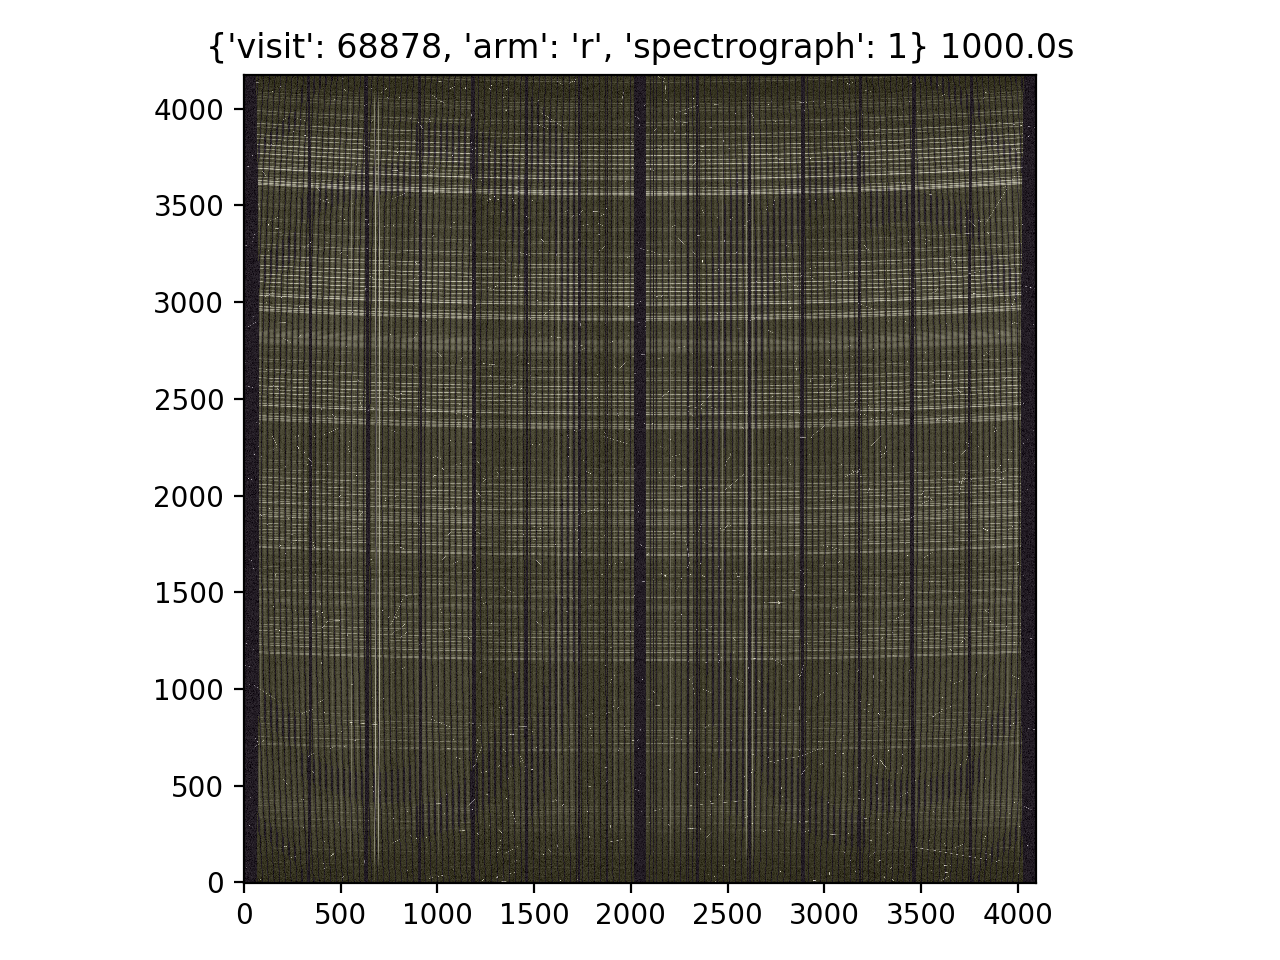

In [254]:
disp = afwDisplay.Display(0, )
disp.scale('asinh', 'zscale')
disp.mtv(exp, title=f"{dataId} {exp.getInfo().getVisitInfo().getExposureTime():.1f}s")

plt.imshow(mask, alpha=0.1, origin='lower')

In [255]:
boxes = alfib.boxCarExtraction(exp.image.array, fiberTraces)

In [256]:
waves = np.array([detMap.getWavelength(fiberId) for fiberId in fiberIds])

<IPython.core.display.Javascript object>


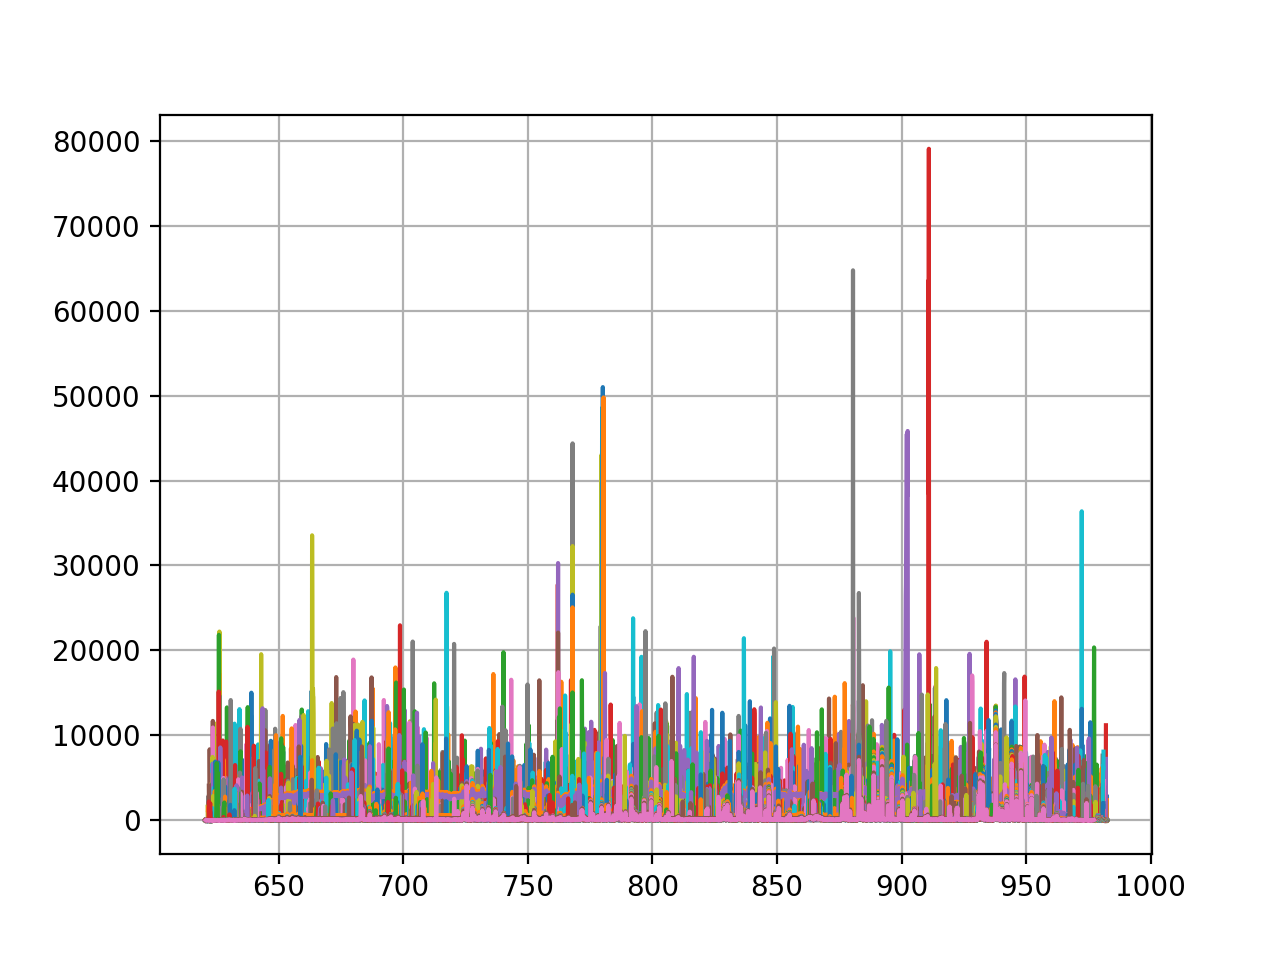

In [257]:
plt.figure()

for i in range(boxes.shape[0]):
    plt.plot(waves[i], boxes[i])
    
plt.grid()

In [258]:
perFiber = np.sum(boxes, axis=1)

In [259]:
perFiberNorm = perFiber/perFiber.max()

<IPython.core.display.Javascript object>


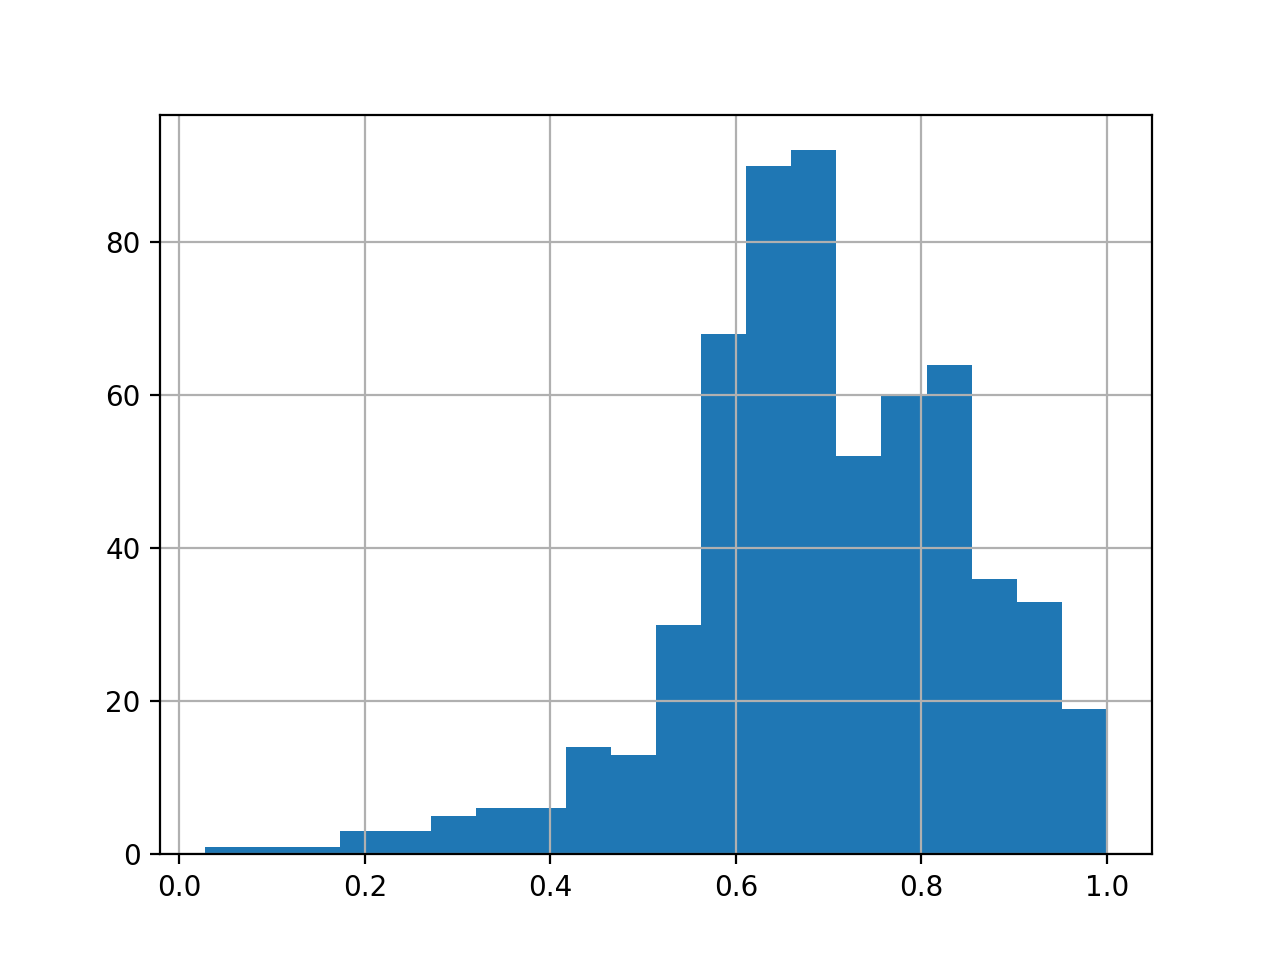

In [221]:
plt.figure()

plt.hist(perFiberNorm, bins=20)
plt.grid()

<IPython.core.display.Javascript object>


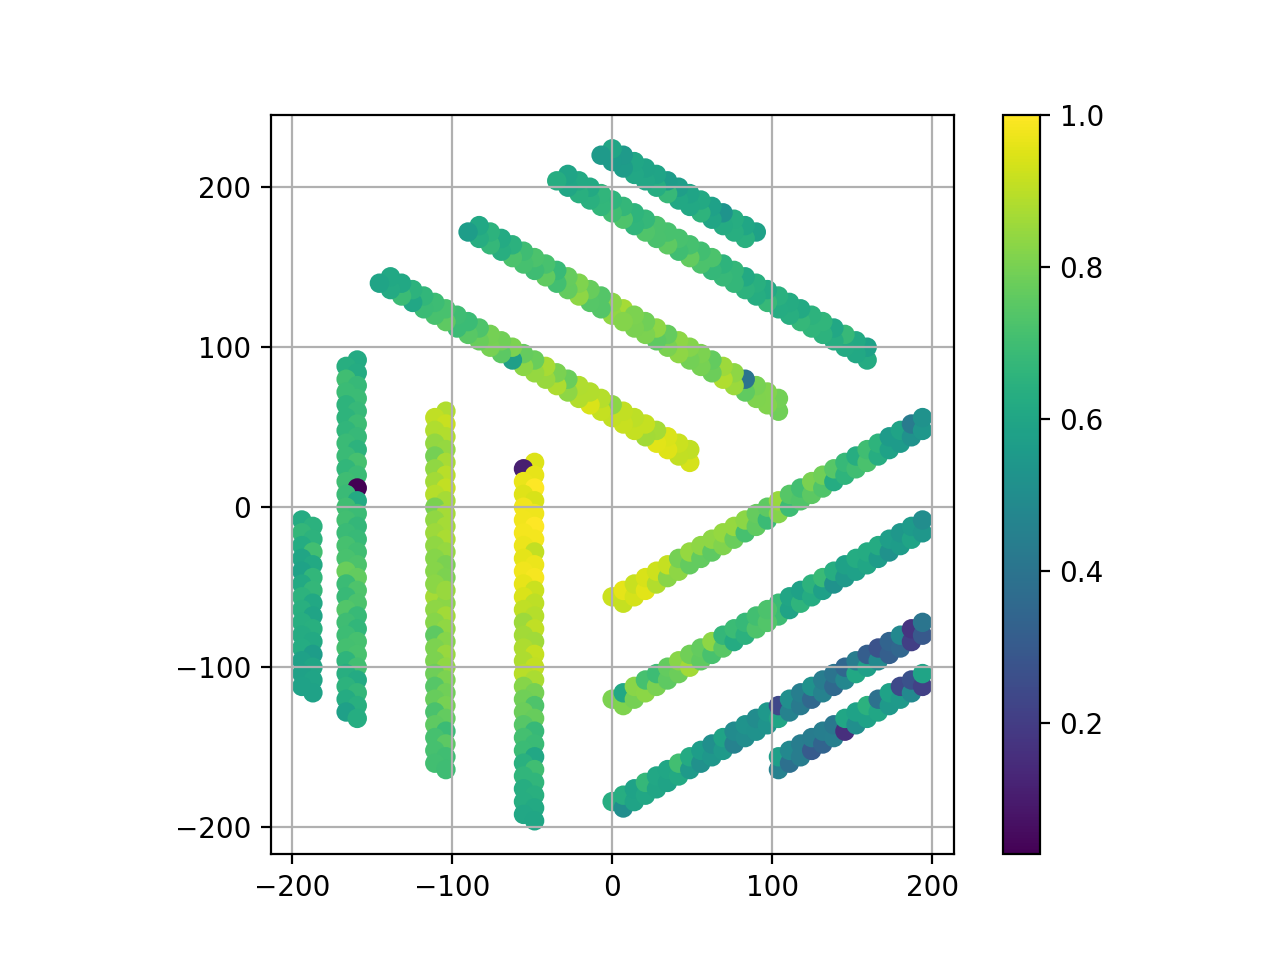

In [38]:
plt.figure()

plt.scatter(spec1.x, spec1.y, c=perFiberNorm)
plt.grid()

plt.gca().set_aspect('equal');
plt.colorbar()

In [222]:
from scipy.optimize import curve_fit

def poly2d(X, a1, a2, b1, b2, c1, c2, d):
    x = X[0]
    y = X[1]
    return a1*x**3 + a2*y**3 + b1*x**2 + b2*y**2 +c1*x+c2*y+d

In [223]:
X = spec1.x.to_numpy()
Y = spec1.y.to_numpy()
Z = perFiberNorm

In [224]:
xdata = np.vstack((X, Y))

In [225]:
popt, pcov = curve_fit(poly2d, xdata, Z)

In [226]:
xModel = np.linspace(-200, 200)
yModel = np.linspace(-200, 200)

In [227]:
xModel,yModel = np.meshgrid(xModel,yModel)

In [228]:
xModel = xModel.ravel()
yModel = yModel.ravel()

In [129]:
zModel = poly2d(np.vstack((xModel, yModel)), *popt)

<IPython.core.display.Javascript object>


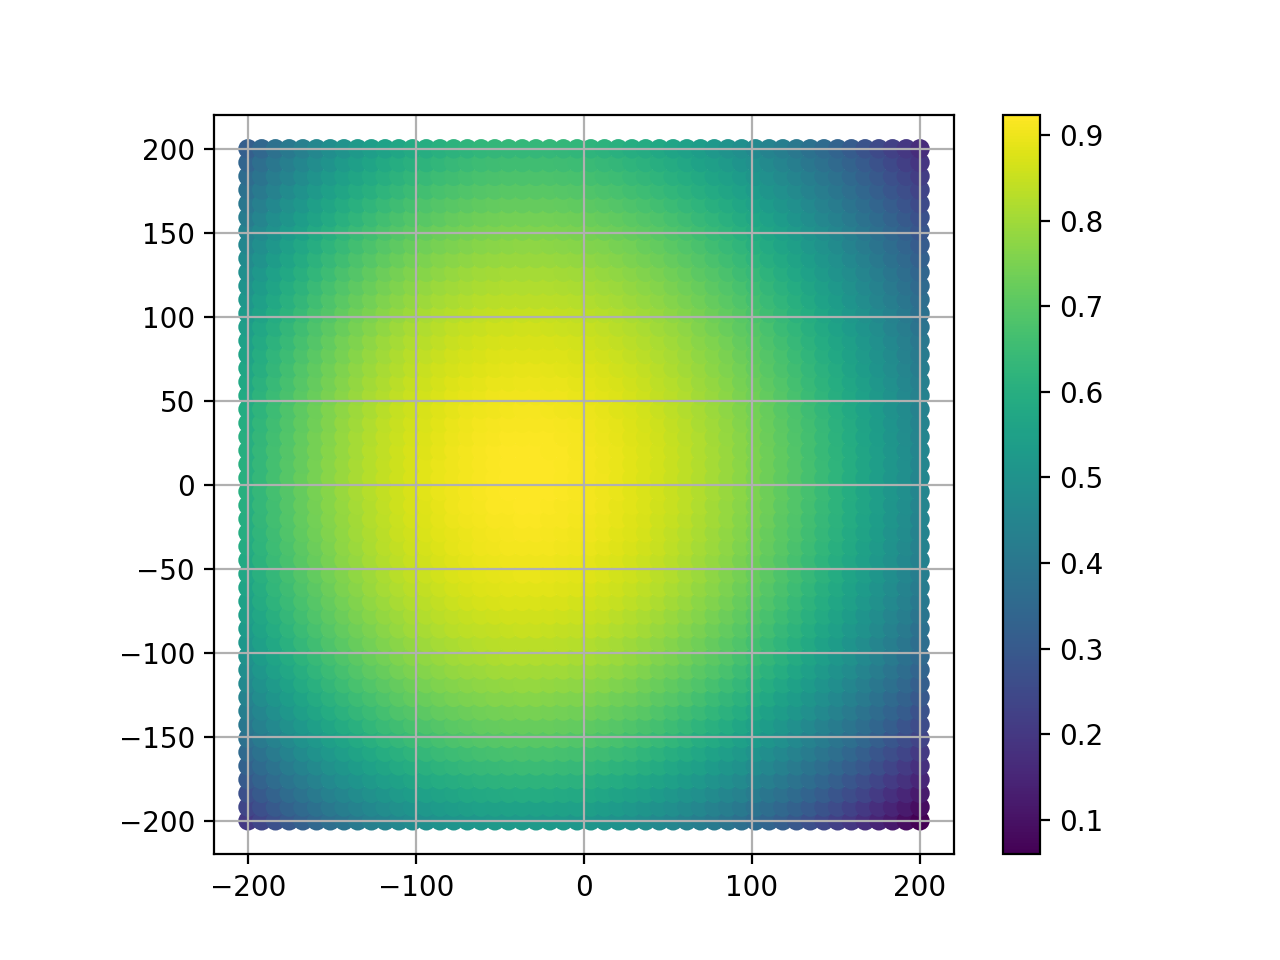

In [229]:
plt.figure()

plt.scatter(xModel, yModel, c=zModel)
plt.grid()

plt.gca().set_aspect('equal');
plt.colorbar()

In [236]:
perFiberNormModel = poly2d(np.vstack((spec1.x, spec1.y)), *popt)

In [237]:
resid = perFiberNorm-perFiberNormModel

<IPython.core.display.Javascript object>


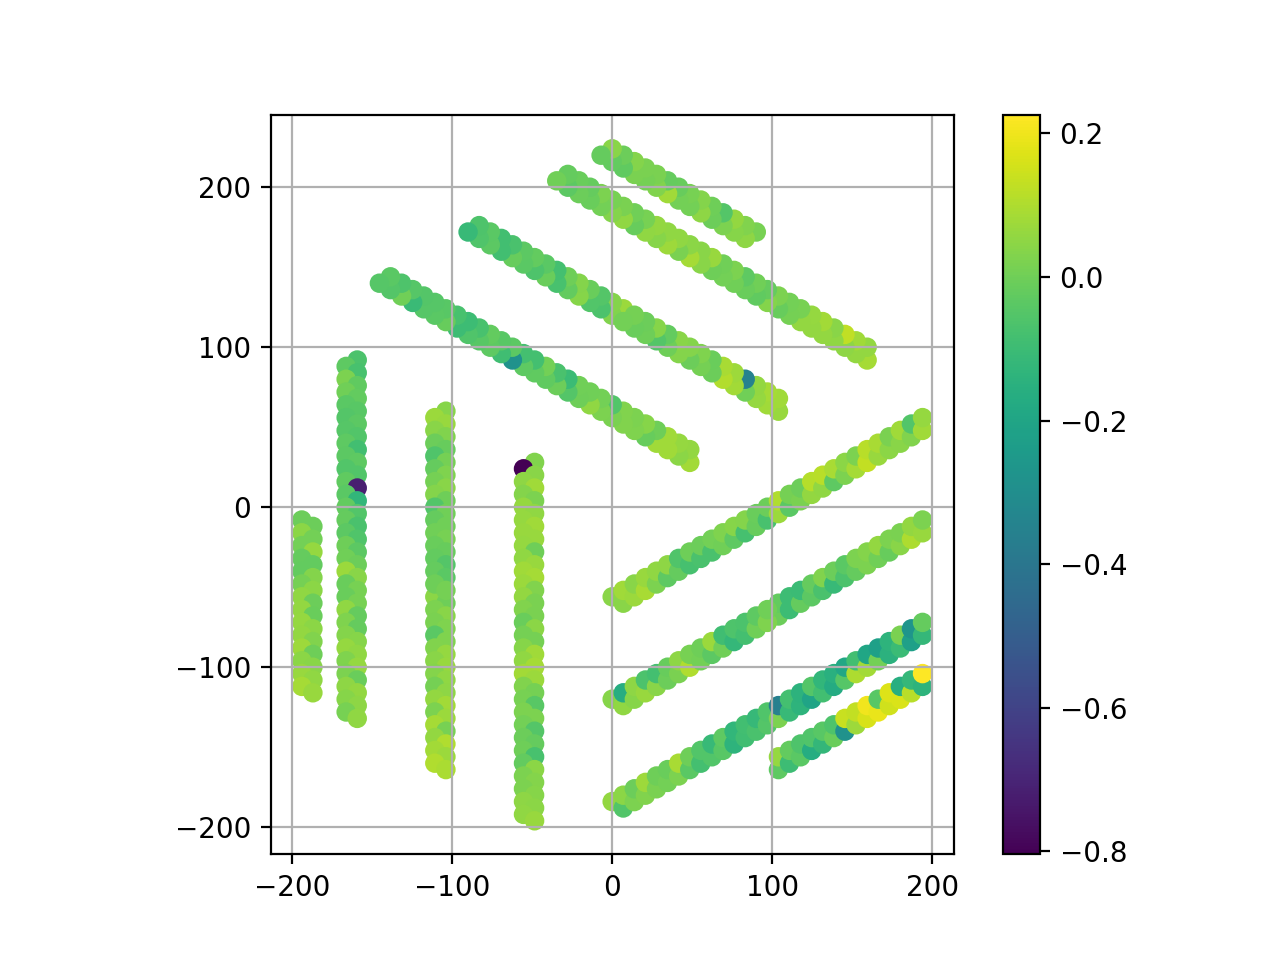

In [238]:
plt.figure()

plt.scatter(spec1.x, spec1.y, c=resid)
plt.grid()

plt.gca().set_aspect('equal');
plt.colorbar()

In [239]:
bads = alfib.robustSigmaClip(resid, sigma=2)

<IPython.core.display.Javascript object>


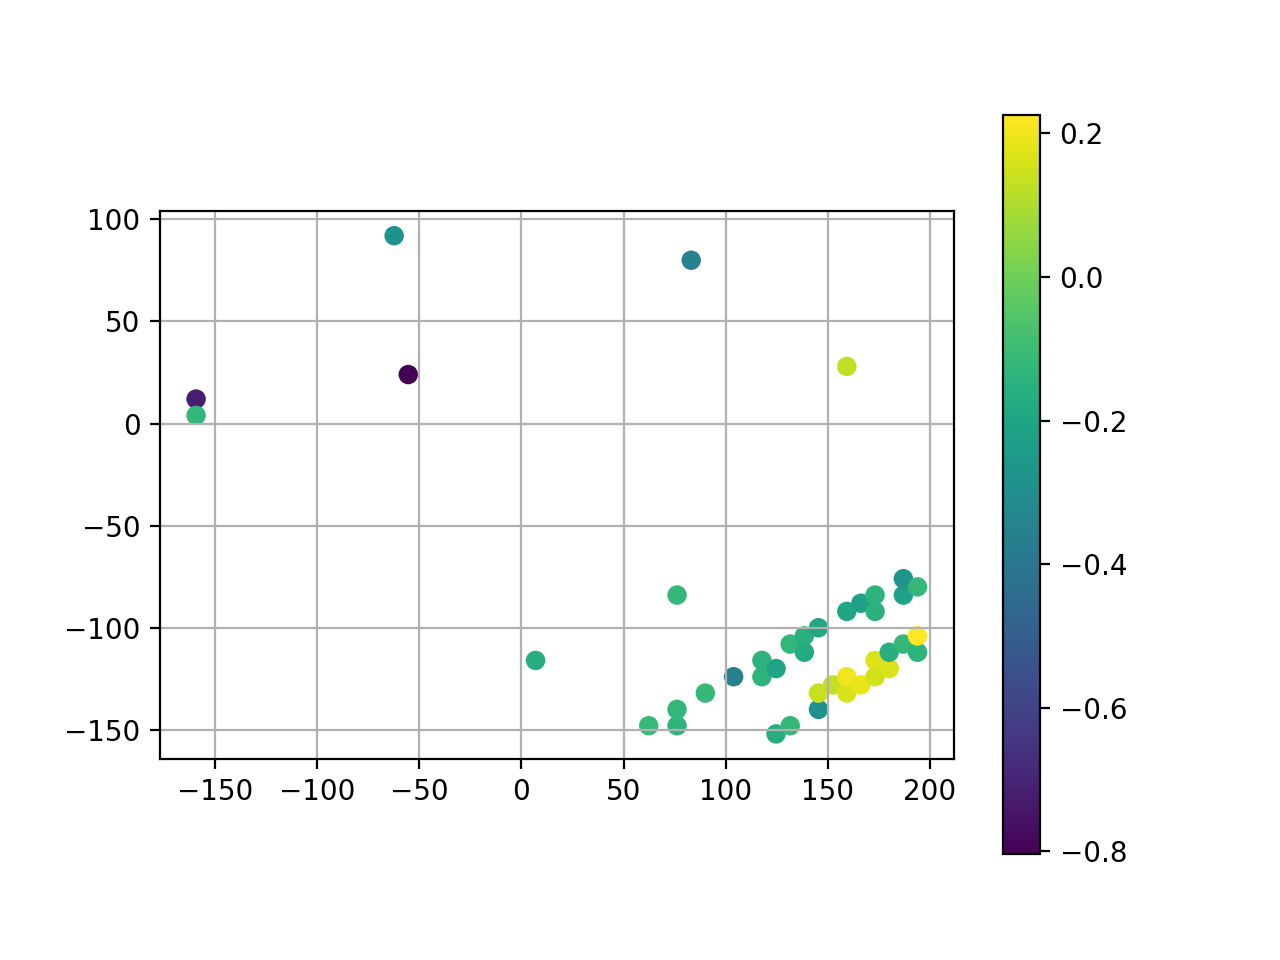

In [240]:
plt.figure()

plt.scatter(spec1.x[bads], spec1.y[bads], c=resid[bads])
plt.grid()

plt.gca().set_aspect('equal');
plt.colorbar()

In [156]:
perFiberNormTrace = perFiberNorm.copy()

In [279]:
perFiberNormModel

array([0.916613  , 0.91524523, 0.9191108 , 0.9172157 , 0.9205503 ,
       0.9181207 , 0.9209173 , 0.91794616, 0.9201977 , 0.91667795,
       0.91837734, 0.91430193, 0.9154421 , 0.9108039 , 0.9113778 ,
       0.90616983, 0.9061703 , 0.90038544, 0.8998055 , 0.8934367 ,
       0.8922692 , 0.8853093 , 0.8835473 , 0.87598926, 0.87362564,
       0.8654624 , 0.86249006, 0.8537146 , 0.8501264 , 0.8547748 ,
       0.85123277, 0.8633276 , 0.85926884, 0.8707894 , 0.8662174 ,
       0.87714756, 0.8720658 , 0.88238966, 0.8768017 , 0.8865042 ,
       0.8804136 , 0.8894766 , 0.88288695, 0.89129555, 0.88421035,
       0.8919486 , 0.88437134, 0.8914232 , 0.88335747, 0.8897072 ,
       0.88115644, 0.8867874 , 0.8777553 , 0.88265187, 0.87314177,
       0.8772879 , 0.86730355, 0.87068325, 0.8796124 , 0.8701129 ,
       0.8788348 , 0.8687304 , 0.87685776, 0.8661599 , 0.8736962 ,
       0.86241937, 0.8693682 , 0.8575239 , 0.86388874, 0.8514895 ,
       0.8572739 , 0.8443321 , 0.84953964, 0.8360662 , 0.84070

<IPython.core.display.Javascript object>


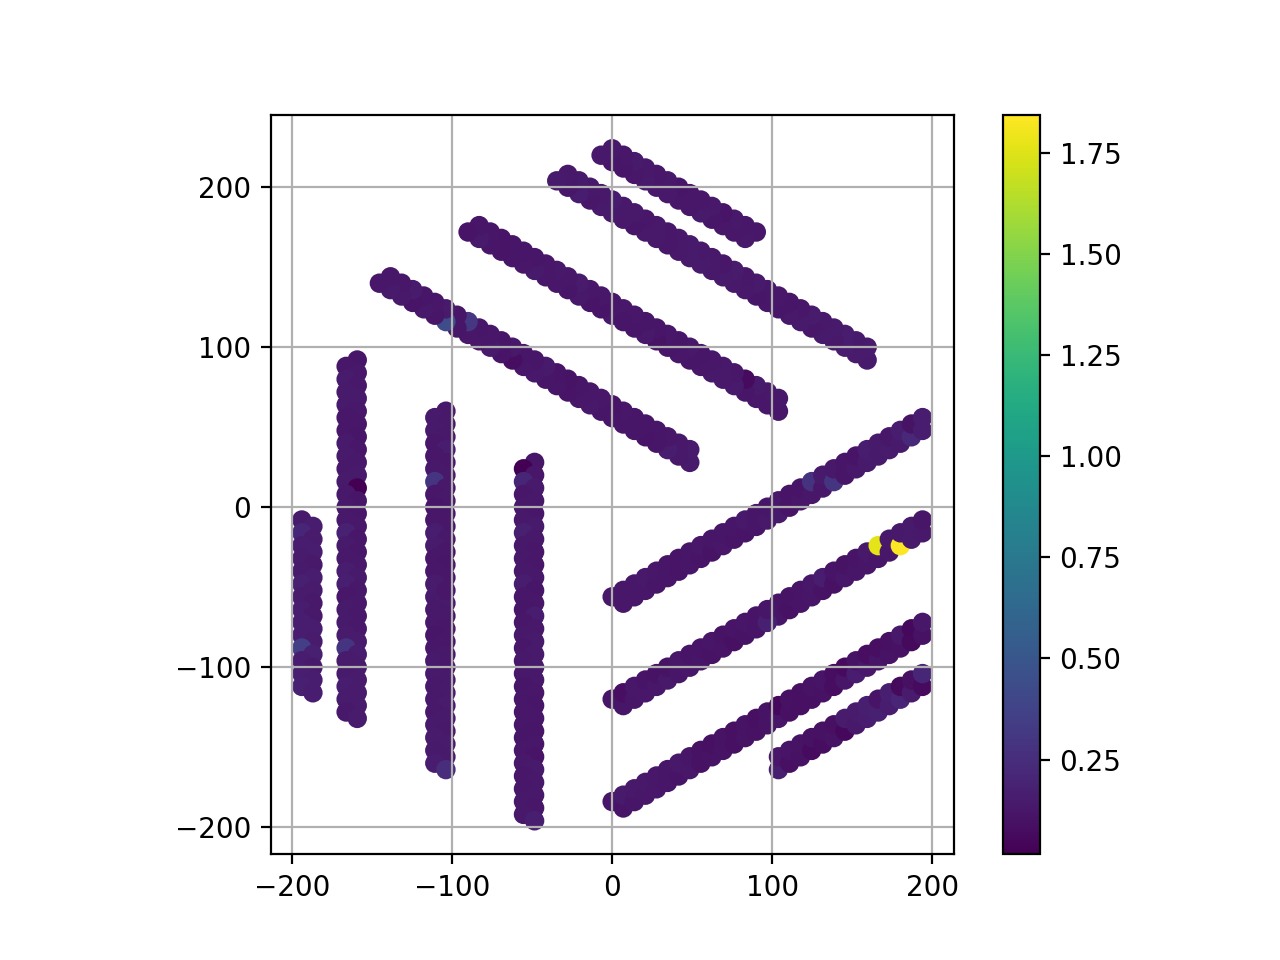

In [308]:
plt.figure()

plt.scatter(spec1.x, spec1.y, c=perFiberNorm/perFiberNormModel)
plt.grid()

plt.gca().set_aspect('equal');
plt.colorbar()

In [261]:
puzz = alfib.robustSigmaClip(perFiberNorm/perFiberNormModel)

In [262]:
fiberIds[puzz]

array([  3,   5,  13, 114, 121, 172, 217, 226, 231, 251, 254, 268, 276,
       285, 295, 296, 299, 301, 353, 360, 362, 366, 372, 376, 377, 380,
       381, 390, 400, 443, 452, 453, 455, 459, 461, 466, 467, 500, 550,
       553, 573, 598, 624, 649], dtype=uint16)

In [290]:
boxesCorrected = boxes / perFiberNormModel[:, None]

In [292]:
skyWaves, skyFlux = waves[~puzz], boxesCorrected[~puzz]

In [265]:
%matplotlib notebook

In [294]:
twmin = max(skyWaves[:,0])

In [295]:
twmax = min(skyWaves[:,-1])

In [296]:
tgrid = np.linspace(twmin, twmax, 4176)

In [297]:
from scipy.interpolate import interp1d

In [303]:
tFluxes = []
for iFib in range(skyWaves.shape[0]):
    f = interp1d(skyWaves[iFib], skyFlux[iFib], kind='cubic')
    tFluxes.append(f(tgrid))
    
tFluxes = np.array(tFluxes)

In [304]:
medSpec = np.nanmedian(tFluxes, axis=0)

<IPython.core.display.Javascript object>


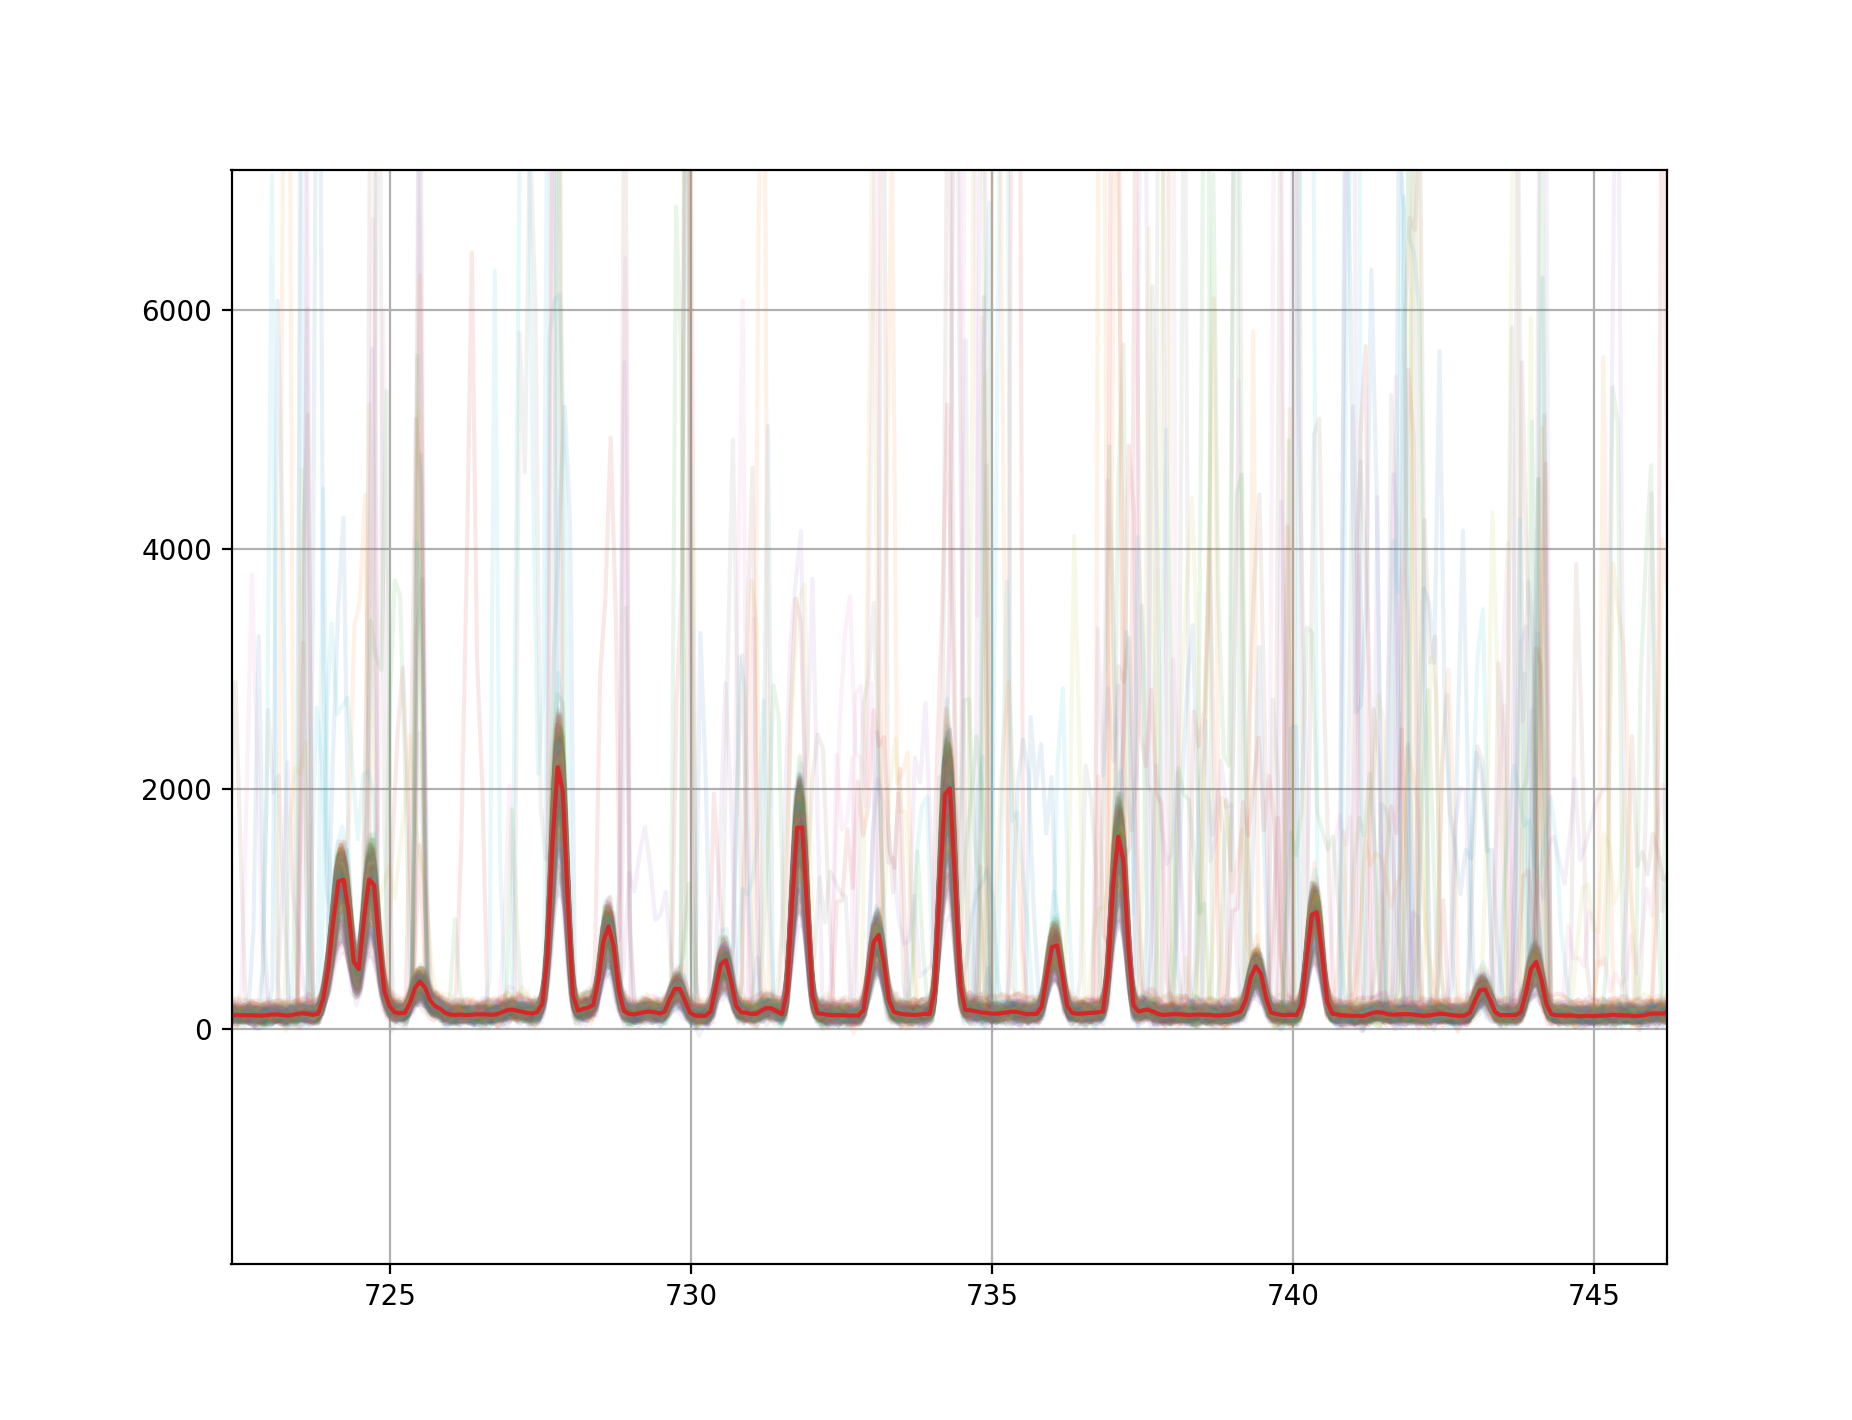

In [307]:
plt.figure()

for i in range(skyFlux.shape[0]):
    plt.plot(skyWaves[i], skyFlux[i], alpha=0.1)
    
plt.plot(tgrid, medSpec)
    
plt.grid()

In [317]:
brighter = np.argsort(perFiber/perFiberNormModel)[-8:]

<IPython.core.display.Javascript object>


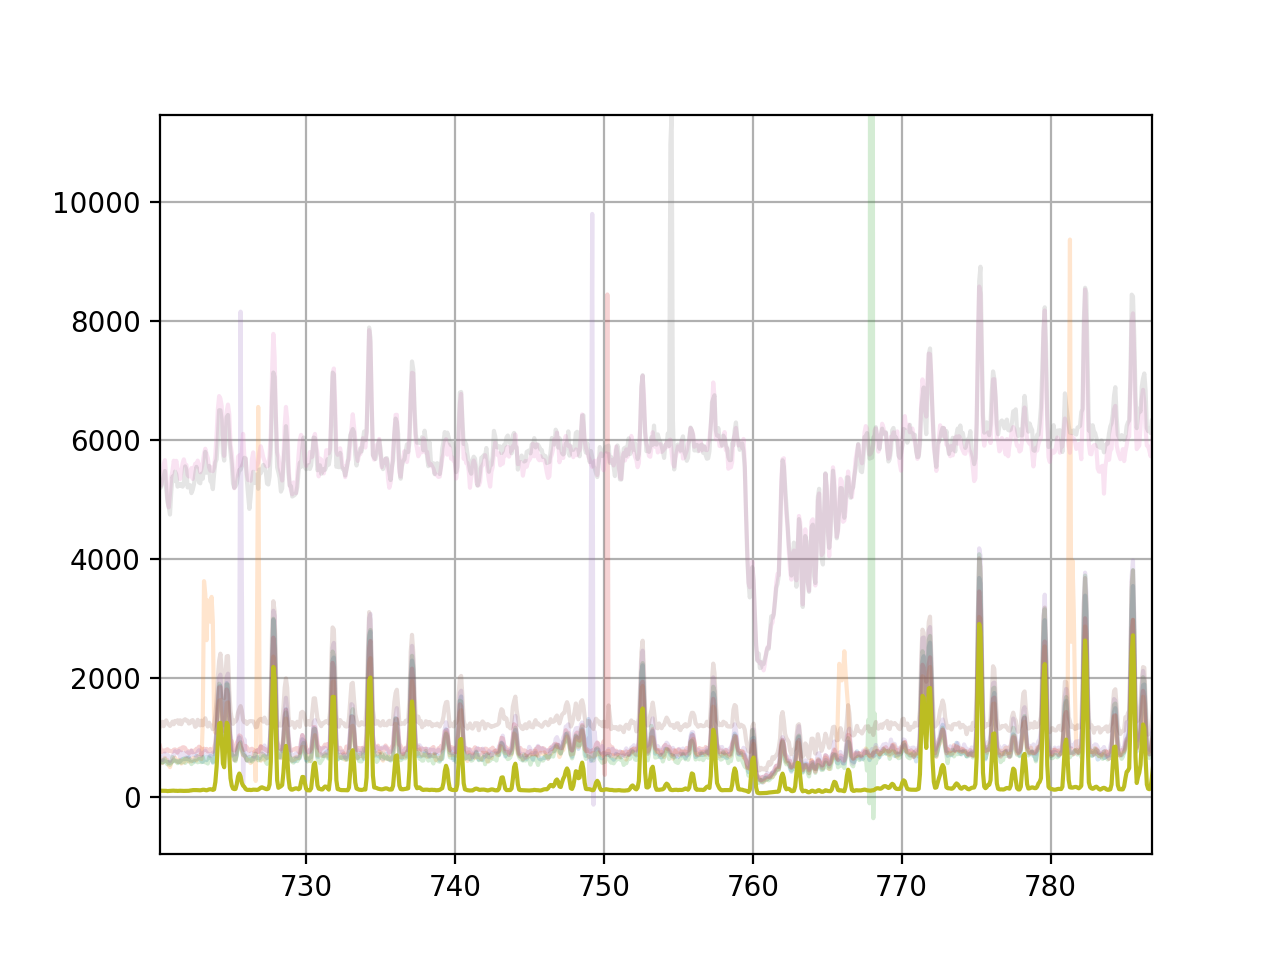

In [324]:
plt.figure()

for iFib in brighter:
    f = interp1d(waves[iFib],boxesCorrected[iFib], kind='cubic')
    plt.plot(tgrid, f(tgrid), alpha=0.2)
    

    
plt.plot(tgrid, medSpec)
plt.grid()

<IPython.core.display.Javascript object>


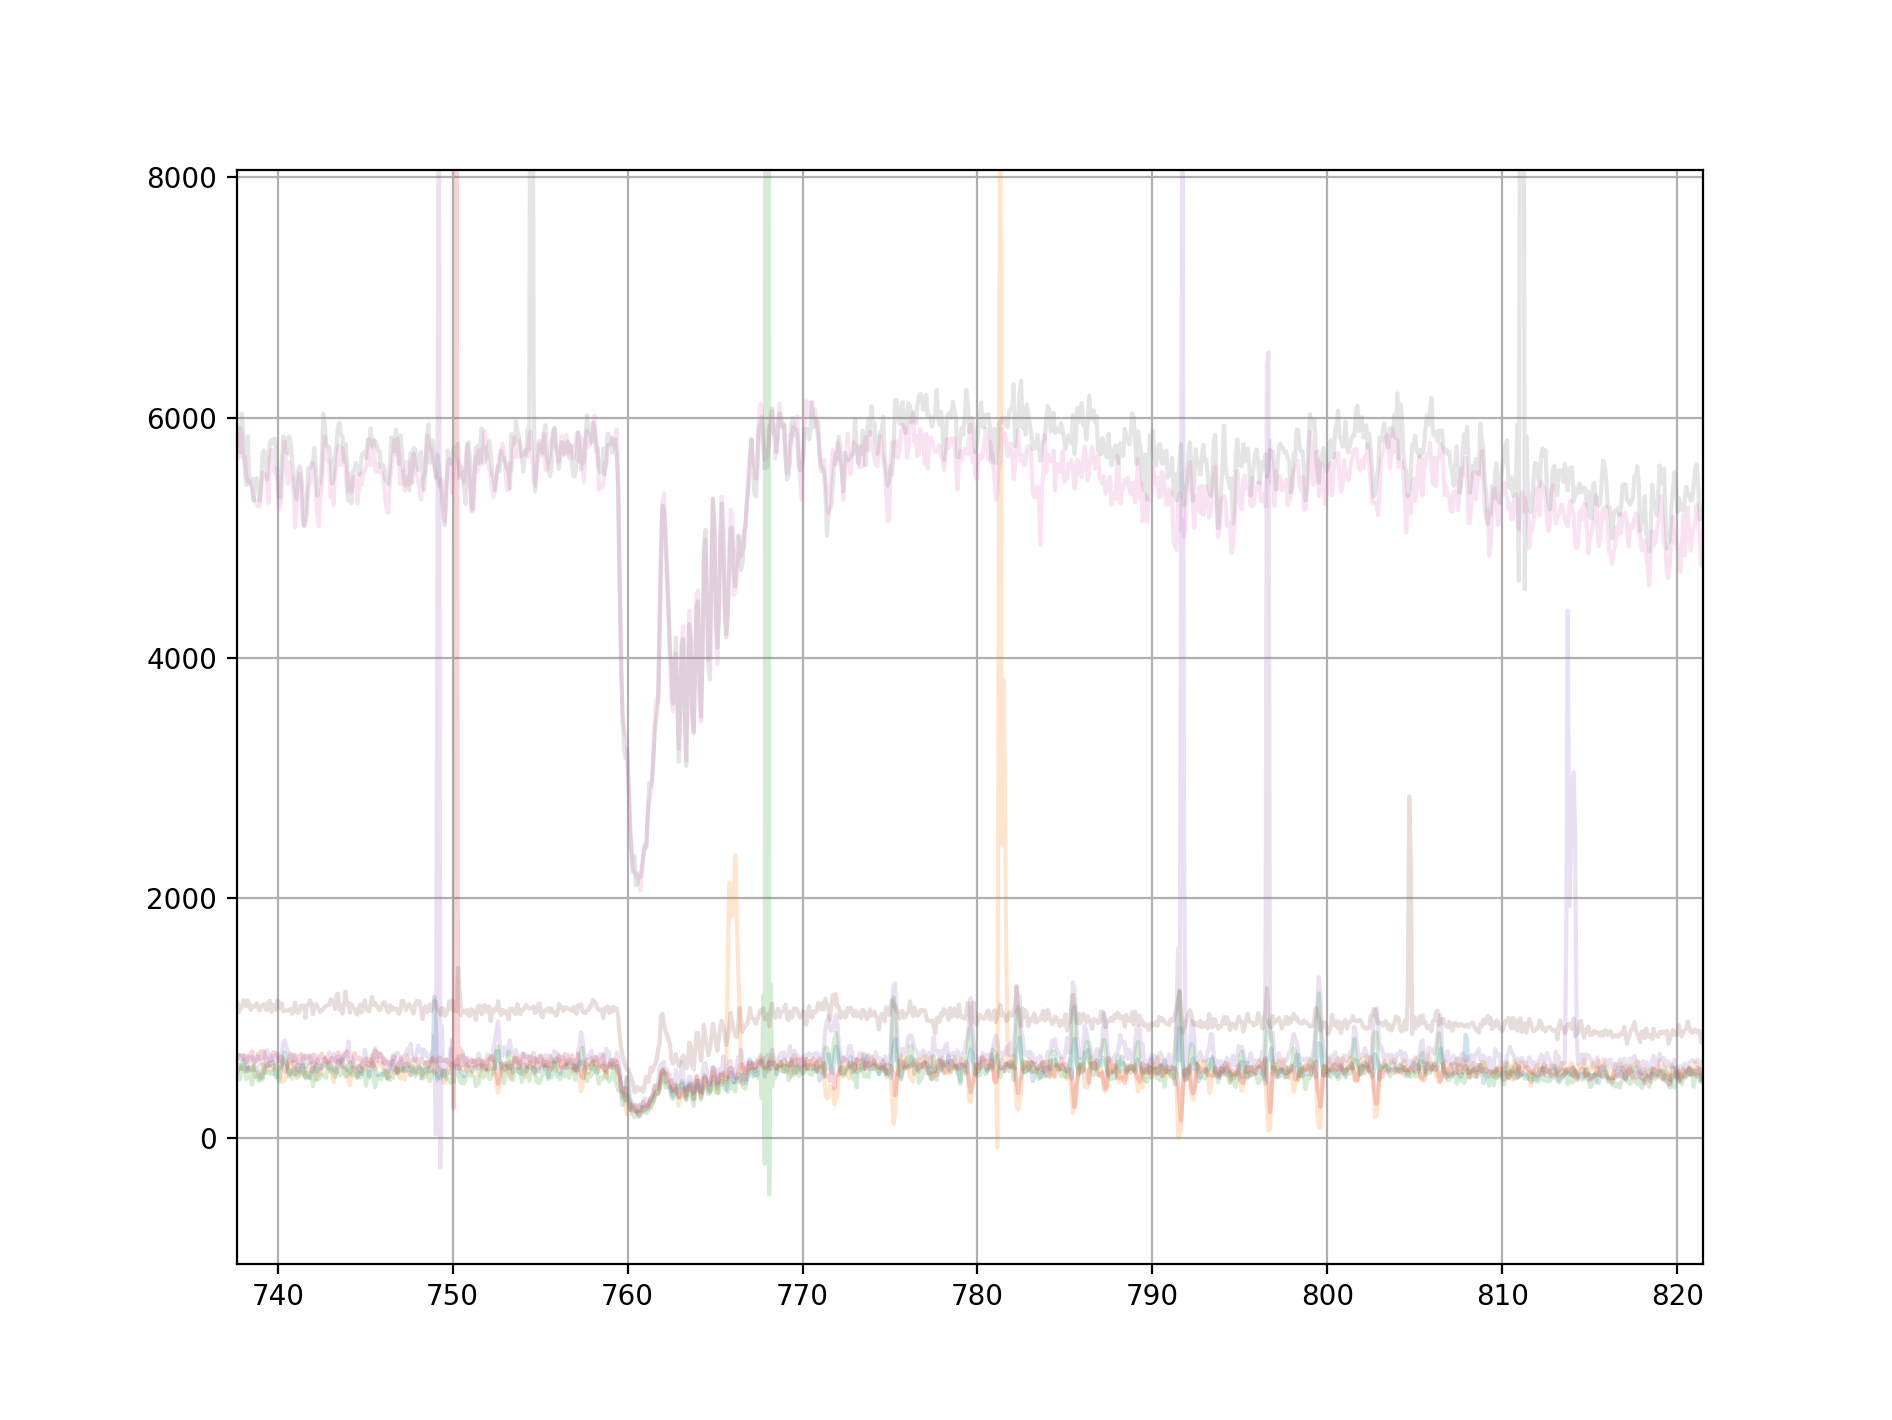

In [325]:
plt.figure()

for iFib in brighter:
    f = interp1d(waves[iFib],boxesCorrected[iFib], kind='cubic')
    plt.plot(tgrid, f(tgrid)-medSpec, alpha=0.2)
    

    
plt.grid()